# Limit of Detection

Drew Porter

## Introduction

The purpose of this notebook is to determine a method limit of detection
using Lake Trout tissue (NIST SRM 1946) for our method of directly
quantifying thiaminase activity in fish tissue extracts using a plate
reader.

Load libraries:

In [ ]:
#| label: setup

library(here)

here() starts at C:/Users/Drew.Porter/Working/r-projects/thiaminase_manuscript

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Background

### Why Lake Trout?

We expect Lake Trout to naturally lack thiaminase, this allows us to
assess the amount of noise or error inherent in our assay in the absence
of thiaminase. Any degradation of thiamine observed during the assay
should be attributable to methodological or instrument-related error.
This is critical for ensuring that when we do detect thiaminase activity
in other samples, the measurement is genuine.

### Sample Handling and Analysis Runs

-   All Lake Trout extracts were prepared from the same frozen NIST
    homogenate on **January 24, 2025**.
-   The assay was conducted over three separate days to account for
    inter-day variability:
    -   **February 7, 2025:** 6 samples (NIST A–F)
    -   **February 10, 2025:** 6 samples (NIST G–L)
    -   **February 11, 2025:** 4 samples (NIST M–P; remaining extract)
-   Note that one run each on **February 6** and **February 11, 2025**
    was discarded due to errors in the calibration standards.

## Data Analysis

### Analysis Method

For each run, the absolute difference in thiamine concentration between
the paired time points was calculated for each sample. The standard
deviation (SD) of these differences was then computed. To establish a
conservative threshold for the assay’s noise, we multiplied the SD by 3.
This value represents the margin of variation that can be attributed to
method error in the absence of thiaminase.

Read in the cleaned limit of detection data:

In [ ]:
#| label: read-lod-data

lod_data <- read_csv(
  here(
    "data", "processed", "lod", "clean_lod_data.csv"
    ),
  col_types = "cDddddddd"
  )

lod_data_long <- read_csv(
  here(
    "data", "processed", "lod", "clean_lod_data_long.csv"
    ), 
  col_types = "cfDddd") |> 
  mutate(time_point = factor(time_point, labels = c("0", "30")))

Calculate the standard deviation of the absolute differences and
multiply it by three to establish a conservative threshold:

In [ ]:
#| label: calc-sd

nist_lod_sd_times3 <- sd(lod_data$abs_thiamine_difference) * 3
print(nist_lod_sd_times3)

[1] 0.495264

Defining fish extract concentration ratios:

In [ ]:
#| label: fish-extract-ratios

fish_g <- 1
buffer_mL <- 2.5
fish_g_per_buffer_mL = fish_g / buffer_mL
extract_vol_in_sample_mL <- 25 / 1000
fish_g_per_sample <- fish_g_per_buffer_mL * extract_vol_in_sample_mL

To make our fish extract we always mix 1 g of homogenized fish tissue
with 2.5 mL phosphate buffer. So, we know there is 0.4 g of fish tissue
per mL of buffer in the extract. We use 25 $\mu$L of fish extract in our
analyses, so we know there is 0.01 g of fish tissue in each analysis
sample.

To convert the calculated absolute difference standard
deviation$\times 3$ to a thiaminase activity rate we simply divide the
value by the grams of fish in each sample, and by the minutes of time
the assay ran for to get thiaminase activity in nmol of thiamine
degraded per gram of fish tissue per minute:

In [ ]:
#| label: calculate-rates

ten_minute_rate_lod <- nist_lod_sd_times3 / fish_g_per_sample / 10
print(ten_minute_rate_lod)

[1] 4.95264

[1] 1.65088

Saving the LOD values for the manuscript:

In [ ]:
#| label: save-lod-values

write_rds(
  ten_minute_rate_lod,
  here("data", "processed", "lod", "ten_min_lod.rds")
)

write_rds(
  thirty_minute_rate_lod,
  here("data", "processed", "lod", "thirty_min_lod.rds")
)

### Data Visualization

Here I plot all the NIST LOD data so we can visualize the difference
between the readings at each time point:

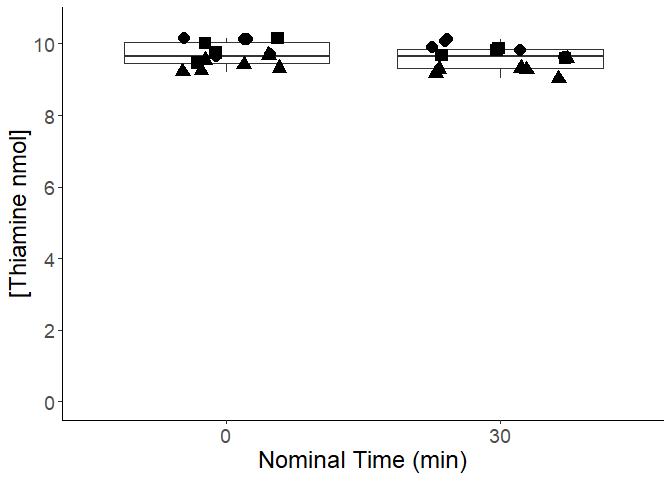

In [ ]:
#| label: fig-lod-boxplot
#| fig-cap: "Thiamine concentrations in SRM 1946 before and after 30 min incubation show no significant change (paired *t*-test, *p* = 0.36). Different shapes represent measurements from separate analysis days."
#| fig-alt: "Method limit of detection box plot figure"

lod_plot <- lod_data_long |> 
  ggplot(aes(x = time_point, y = avg_thiamine)) +
  geom_boxplot() +
  geom_jitter(aes(shape = factor(analysis_date)),
              width = jitter_width, height = jitter_height, size = point_size) +
  #stat_compare_means(method = "t.test",
                    # paired = TRUE,
                    # label.x = 0.75,
                     #label.y = 10.45,
                   #  aes(label = paste0("Paired t-test, p = ",
                                #    after_stat(p.format)))) +
  scale_y_continuous(limits = c(0, 10.5), breaks = seq(0, 10, 2)) +
  labs(x = "Nominal Time (min)",
       y = "[Thiamine nmol]") +
  guides(shape = "none") +
  theme_classic() +
  theme(text = element_text(size = text_size))

lod_plot

### Statistical Analysis

The goal here is to perform a paired t-test to determine if the 30 min
incubation period caused a change in thiamine concentration in the NIST
samples. From the plot, I expect there to be no significant difference.

First I need to make sure we are meeting the assumptions of a paired
t-test:

-   The data are continuous (yes)

-   The data values are paired measurements (yes)

-   The pairs are independent of each other (yes)

-   The differences between paired observations are normally distributed
    (check below)

    ``` r
    #| label: normality-test

    # Calculate the differences between paired observations
    differences <- lod_data$avg_thiamine_t1 - lod_data$avg_thiamine_t0

    # Perform a Shapiro-Wilk normality test on the differences
    shapiro_test <- shapiro.test(differences)
    print(shapiro_test)
    ```


            Shapiro-Wilk normality test

        data:  differences
        W = 0.97789, p-value = 0.9446

The high p-value of 0.945 indicates that the differences are normally
distributed and I can proceed with the paired t-test:

In [ ]:
#| label: paired-t-test

t_test_result <- t.test(lod_data$avg_thiamine_t0, 
                        lod_data$avg_thiamine_t1,
                        paired = TRUE)

print(t_test_result)


    Paired t-test

data:  lod_data$avg_thiamine_t0 and lod_data$avg_thiamine_t1
t = 0.95099, df = 15, p-value = 0.3567
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.07957522  0.20778910
sample estimates:
mean difference 
     0.06410694 

Since the p-value (0.357) is much higher than 0.05 and the confidence
interval includes zero, we conclude that there is no statistically
significant difference between the average thiamine measurements at time
0 and time 1.

Saving t-test p-value for reference in manuscript:

In [ ]:
lod_paired_p_val <- t_test_result$p.value

write_rds(
  lod_paired_p_val,
  file = here("data", "processed", "lod", "lod_paired_p_val.rds")
)